In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mlp

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# dev = 'cpu'
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

In [3]:
data_path = '/home/z5370003/projects/neuralops-l63/data/l63-6.5T'

In [4]:
# Data path
mesh_path = os.path.join(data_path, 'mesh.npy')
pdfn_path = os.path.join(data_path, 'prior.npy')

# Read numpy matrices
mesh = torch.from_numpy(np.load(mesh_path).reshape((1, 40, 40, 40, 3)))
pdfn = torch.from_numpy(np.load(pdfn_path).reshape((-1, 40, 40, 40, 1)))

# pdfn = pdfn[:166]
# pdfn = pdfn.repeat((3, 1, 1, 1, 1))

In [5]:
# pdfflat = pdf2d.view(499, -1)
pdfmin = pdfn.min() #pdfflat.min(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdfmax = pdfn.max() # pdfflat.max(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdfn = ((pdfn - pdfmin)/(pdfmax - pdfmin))

In [6]:
pdfn.shape, mesh.shape

(torch.Size([541, 40, 40, 40, 1]), torch.Size([1, 40, 40, 40, 3]))

In [7]:
p = torch.concat([pdfn, mesh.repeat(pdfn.shape[0], 1, 1, 1, 1)], dim=-1)
p = torch.concat([p, p[-1:]], dim=0)
# p = torch.concat([p, ts], dim=-1)
p.shape

torch.Size([542, 40, 40, 40, 4])

In [8]:
from torch.utils.data import  Dataset
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [9]:
def get_dataset(p, n_steps=10):
    xs = []
    ys = []
    for i in range(0, p.shape[0]-n_steps):
        xs.append(p[i])
        ys.append(p[i+n_steps, ..., 0].unsqueeze(-1))
    x = torch.stack(xs, dim=0).permute(0, 4, 1, 2, 3)
    y = torch.stack(ys, dim=0).permute(0, 4, 1, 2, 3)
    return DictDataset(x, y)

In [10]:
full_ds = get_dataset(p, n_steps=10)
train_size = int(0.7 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, 
                                                  [train_size, test_size])


In [11]:
full_ds[0]['x'].shape

torch.Size([4, 40, 40, 40])

In [12]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [13]:
import sys
from models.fno import FNO
from neuralop.training import Trainer
from neuralop.utils import count_model_params
from models.losses import LpLoss, H1Loss

In [14]:
model = FNO(n_modes=(16, 16, 16), in_channels=4, hidden_channels=64, 
            projection_channels=128, rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 75540289 parameters.


In [15]:
init_lr = 1e-2
stop_lr = 1e-4

optimizer = torch.optim.Adam(model.parameters(), 
                                lr=init_lr, 
                                weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
lr_step_rate = 5
log_rate = 10


l2loss = LpLoss(d=3, p=2)
h1loss = H1Loss(d=3)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [16]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv3d(4, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(256, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(128, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (convs): SpectralConv(
    (weight): ModuleList(
      (0-3): 4 x ComplexDenseTensor(shape=torch.Size([64, 64, 16, 16, 9]), rank=None)
    )
  )
  (fno_skips): ModuleList(
    (0-3): 4 x Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <models.losses.H1Loss object 

In [17]:
n_epochs = 500

train_losses = []
test_losses = []


for epoch in range(n_epochs):

    avg_loss = 0
    avg_lasso_loss = 0
    model.train()
    train_err = 0.0
    
    avg_test_loss = 0
    test_err = 0.0

    for idx, sample in enumerate(train_dl):

        # load everything from the batch onto self.device if 
        # no callback overrides default load to device
        

        for k,v in sample.items():
            if hasattr(v, 'to'):
                sample[k] = v.to(device)

        optimizer.zero_grad(set_to_none=True)
        out = model(**sample)

        loss = 0.
        
        if isinstance(out, torch.Tensor):
            loss = train_loss(out.float(), **sample)
        elif isinstance(out, dict):
            loss += train_loss(**out, **sample)
        
        del out
        
        loss.backward()
        
        optimizer.step()
        train_err += loss.item()

        with torch.no_grad():
            avg_loss += loss.item()

    curr_lr = scheduler.get_last_lr()[0]
            
    if (epoch + 1) % lr_step_rate == 0 and curr_lr > stop_lr:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(train_err)
        else:
            scheduler.step()

    train_err /= len(train_dl)
    avg_loss  /= n_epochs
    
    
    if epoch == 0 or (epoch + 1) % log_rate == 0:
        model.eval()
        for idx, sample in enumerate(test_dl):

            # load everything from the batch onto self.device if 
            # no callback overrides default load to device


            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(**sample)

            loss = 0.

            if isinstance(out, torch.Tensor):
                loss = train_loss(out.float(), **sample)
            elif isinstance(out, dict):
                loss += train_loss(**out, **sample)

            del out

            test_err += loss.item()

            with torch.no_grad():
                avg_test_loss += loss.item()

        test_err /= len(test_dl)
        avg_test_loss  /= n_epochs
        
        
        train_losses.append(avg_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Epoch: {epoch+1} loss: {avg_loss:.4f}  test loss: {avg_test_loss:.4f} lr: {curr_lr:.4f}')

Epoch: 1 loss: 47.9822  test loss: 1.7908 lr: 0.0100
Epoch: 10 loss: 0.6101  test loss: 0.2596 lr: 0.0095
Epoch: 20 loss: 0.4565  test loss: 0.1688 lr: 0.0086
Epoch: 30 loss: 0.3140  test loss: 0.1225 lr: 0.0077
Epoch: 40 loss: 0.2110  test loss: 0.0888 lr: 0.0070
Epoch: 50 loss: 0.2225  test loss: 0.1079 lr: 0.0063
Epoch: 60 loss: 0.1444  test loss: 0.0653 lr: 0.0057
Epoch: 70 loss: 0.1395  test loss: 0.0631 lr: 0.0051
Epoch: 80 loss: 0.1886  test loss: 0.0736 lr: 0.0046
Epoch: 90 loss: 0.1356  test loss: 0.0567 lr: 0.0042
Epoch: 100 loss: 0.1083  test loss: 0.0488 lr: 0.0038
Epoch: 110 loss: 0.1100  test loss: 0.0471 lr: 0.0034
Epoch: 120 loss: 0.1086  test loss: 0.0484 lr: 0.0031
Epoch: 130 loss: 0.1065  test loss: 0.0492 lr: 0.0028
Epoch: 140 loss: 0.0944  test loss: 0.0438 lr: 0.0025
Epoch: 150 loss: 0.0928  test loss: 0.0516 lr: 0.0023
Epoch: 160 loss: 0.0850  test loss: 0.0398 lr: 0.0020
Epoch: 170 loss: 0.0853  test loss: 0.0381 lr: 0.0018
Epoch: 180 loss: 0.0880  test loss: 0.

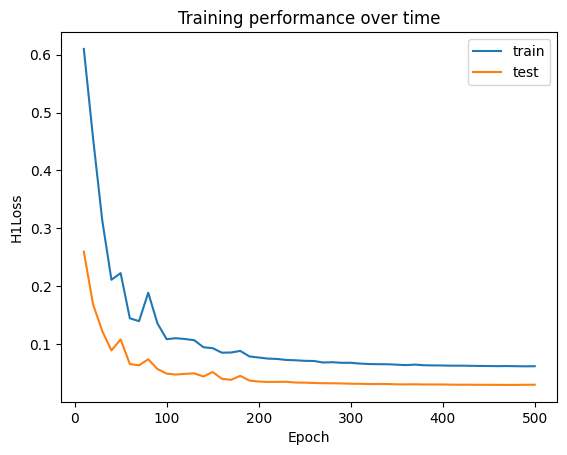

In [25]:
fig, ax = plt.subplots()

log_epochs = np.insert(np.arange(0, n_epochs, 10) + 10, 0, 1)

ax.plot(log_epochs[1:], train_losses[1:], label='train')
ax.plot(log_epochs[1:], test_losses[1:], label='test')

ax.set_title('Training performance over time')
ax.set_ylabel('H1Loss')
ax.set_xlabel('Epoch')
ax.legend()


In [29]:
import matplotlib as mlp

def scale(x):
    x_max = x.max()
    x_min = x.min()
    return (x - x_min)/(x_max - x_min)

def plot_pdf(x, y, z, a, p, pred):

    cmap = plt.cm.viridis
    ss = 900
    
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 32), 
                           subplot_kw=dict(projection='3d'), 
                           constrained_layout=True)
    
    norm = mlp.colors.Normalize(vmin=a.min(), vmax=a.max())
    ax[0].scatter(x, y, z, s=scale(a)*ss, color=cmap(norm(a)), alpha=0.5)
    ax[0].set_title('Input')
    
    # norm = mlp.colors.Normalize(vmin=p.min(), vmax=p.max())
    ax[1].scatter(x, y, z, s=scale(p)*ss, color=cmap(norm(p)), alpha=0.5)
    ax[1].set_title('Target')
    
    # norm = mlp.colors.Normalize(vmin=pred.min(), vmax=pred.max())
    ax[2].scatter(x, y, z, s=scale(pred)*ss/2, color=cmap(norm(pred)), alpha=0.5)
    ax[2].set_title('Prediction (FNO)')


    # ax.autoscale(False)
    ax[0].set(xlabel='x1', ylabel='x2', zlabel='x3')
    ax[1].set(xlabel='x1', ylabel='x2', zlabel='x3')
    ax[2].set(xlabel='x1', ylabel='x2', zlabel='x3')

    plt.show()

In [30]:
xmesh = mesh[0, :, :, :, 0]
ymesh = mesh[0, :, :, :, 1]
zmesh = mesh[0, :, :, :, 2]

x = xmesh.ravel().numpy()
y = ymesh.ravel().numpy()
z = zmesh.ravel().numpy()

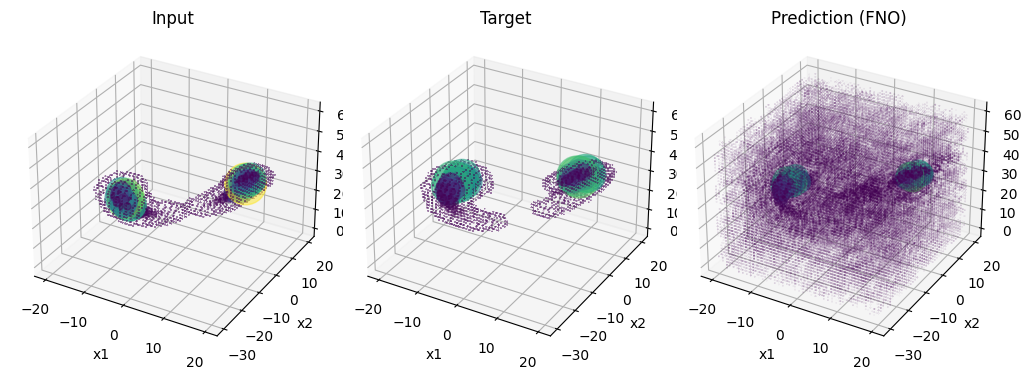

In [31]:
# for ind in range(3, 12, 3):

ind = np.random.randint(len(test_ds))

sample = test_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)


pred = model(a.unsqueeze(0)).relu()[0].cpu().detach().numpy()[0]
p = p.view(40, 40, 40).cpu().detach().numpy()
a = a[0,...].view(40, 40, 40).cpu().detach().numpy()
plot_pdf(x, y, z, a.ravel(), p.ravel(), pred.ravel())

In [32]:
def plot_res_2d(a, p, filename='plot.png'):
    
    fig, ax = plt.subplots(3, 3, figsize=(15, 13))

    labels = {1: ['X2', 'X3'],
              2: ['X1', 'X3'],
              3: ['X1', 'X2']}

    for j in range(1, len(p.shape)):
        pj = p.mean(dim=j)[0].cpu()
        img = ax[0, j-1].imshow(pj, vmin=pj.min(), vmax=pj.max())
        ax[0, j-1].set_title(f"Target - Avg over X{j}")
        ax[0, j-1].set_xlabel(labels[j][0])
        ax[0, j-1].set_ylabel(labels[j][1])
        plt.colorbar(img, format='%.4f')

    pred = model(a.unsqueeze(0)).relu()[0].cpu()

    for j in range(1, len(pred.shape)):
        pj = p.mean(dim=j)[0].cpu()
        img = ax[1, j-1].imshow(pred.mean(dim=j)[0].cpu().detach(), vmin=pj.min(), vmax=pj.max())
        ax[1, j-1].set_title(f"FNO - Avg over X{j}")
        ax[1, j-1].set_xlabel(labels[j][0])
        ax[1, j-1].set_ylabel(labels[j][1])
        plt.colorbar(img, format='%.4f')

        p_map = p.mean(dim=j)[0].cpu()
        pred_map = pred.mean(dim=j)[0].cpu().detach()
        
        err_img = ax[2, j-1].imshow(torch.abs(p_map - pred_map))
        ax[2, j-1].set_title(f"Err - Avg over X{j}")
        ax[2, j-1].set_xlabel(labels[j][0])
        ax[2, j-1].set_ylabel(labels[j][1])
        plt.colorbar(err_img, format='%.4f')

    fig.savefig(filename, bbox_inches='tight')

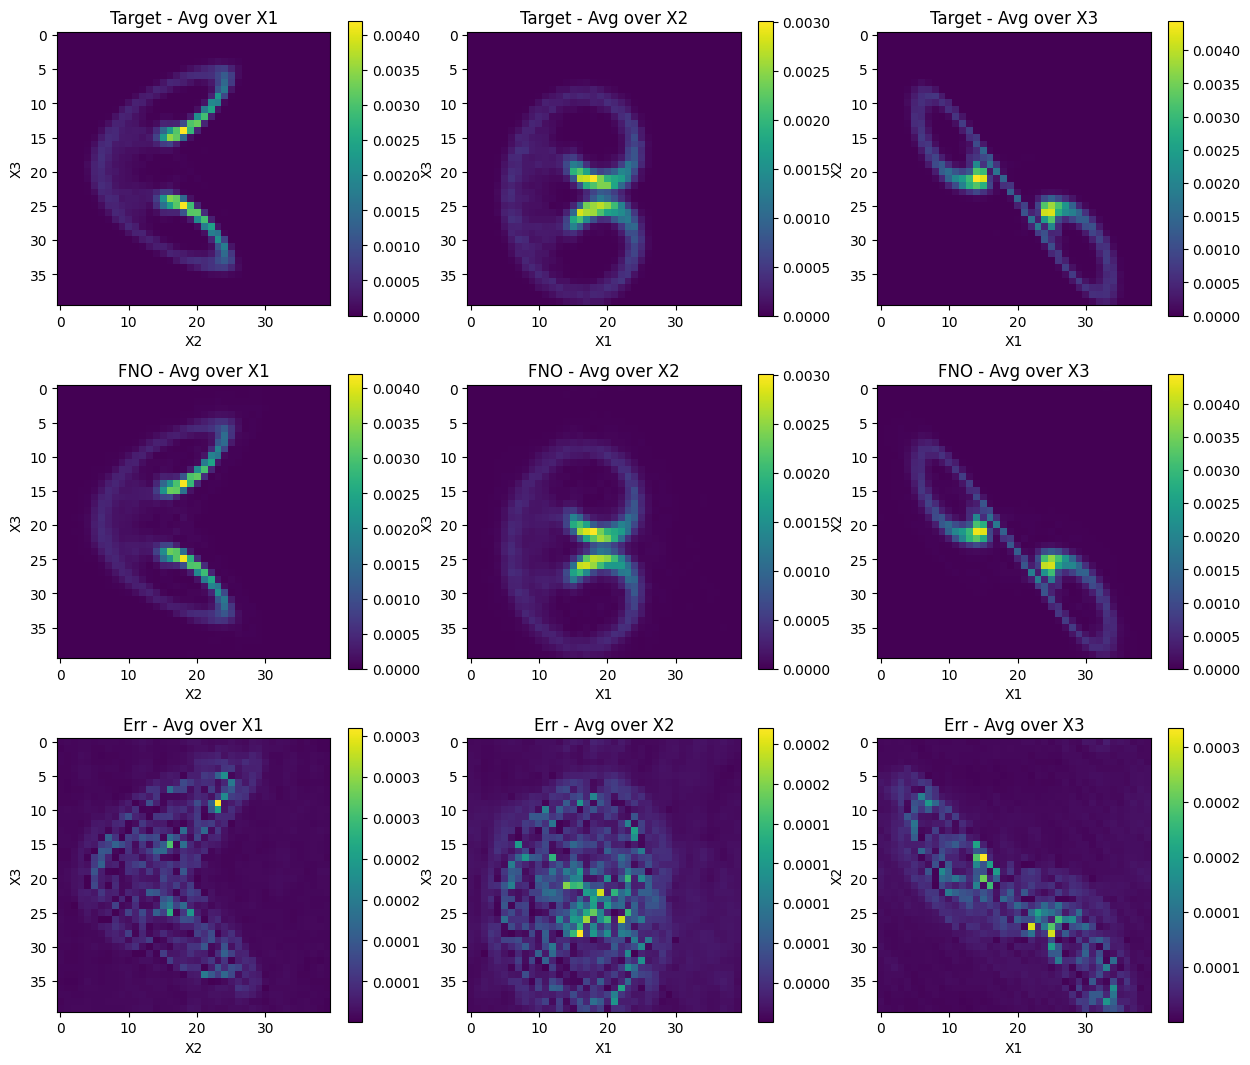

In [33]:
ind = np.random.randint(len(train_ds))
filename = 'plots/prior-3d-proj-train.png'

sample = train_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)

plot_res_2d(a, p, filename)

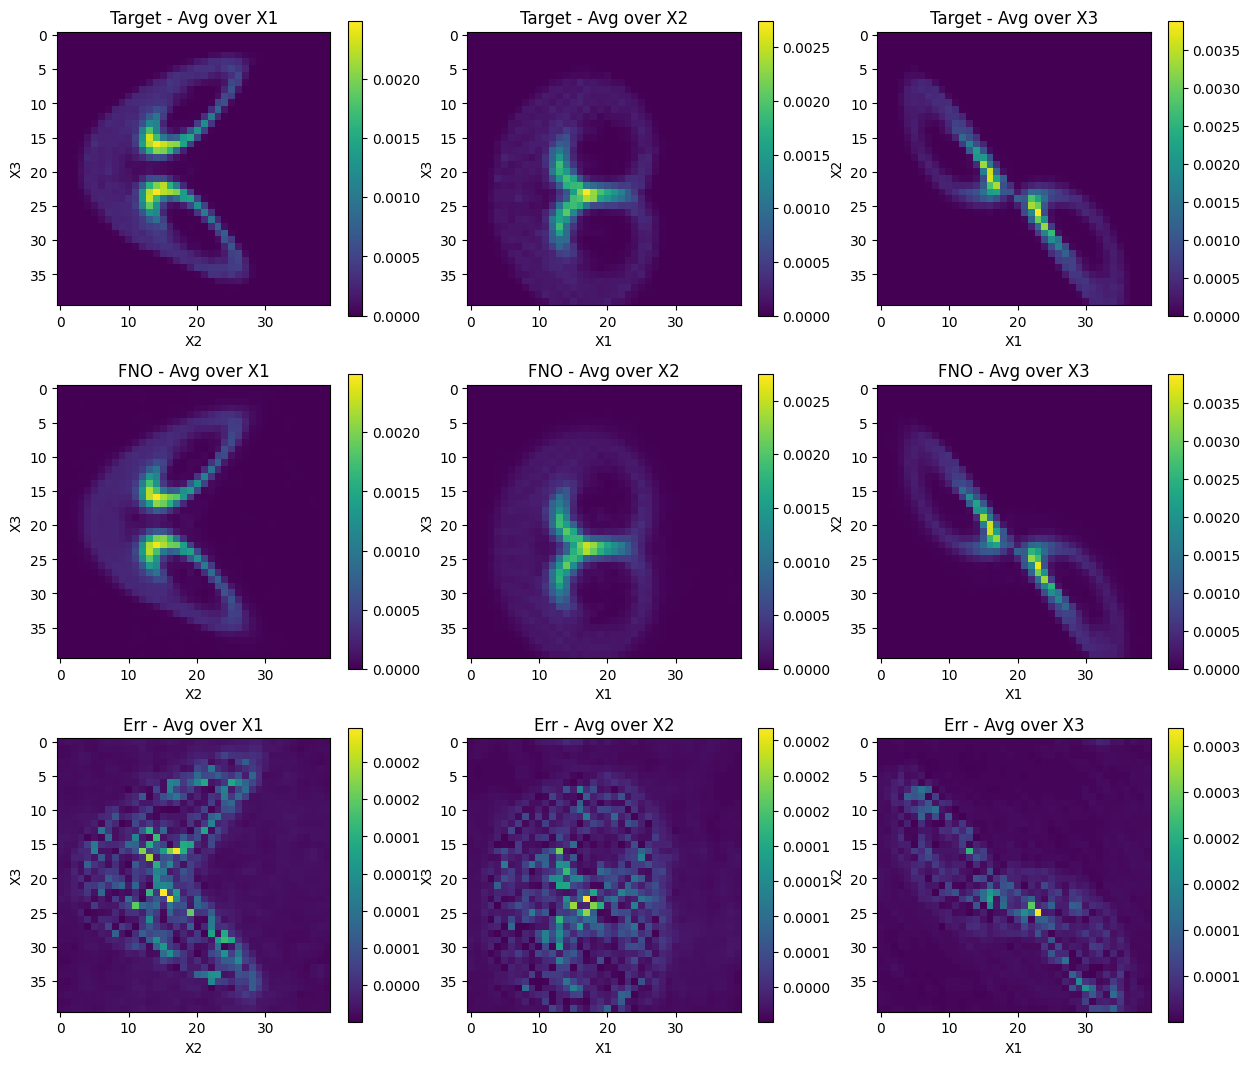

In [34]:
filename = 'plots/prior-3d-proj-test.png'
ind = np.random.randint(len(test_ds))

sample = train_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)

plot_res_2d(a, p, filename)